In [1]:
import collections
import json
import os
import re

import ahocorasick
import networkx as nx
import openai
import pandas as pd
import pdfplumber
from matplotlib import pyplot as plt

dataDir = "../data/"
dataName = "Deep Learning.pdf"

# 设置 api


In [2]:
# openai.api_base = "https://api.chatanywhere.com.cn/"
openai.api_base = "https://api.chatanywhere.cn/"
openai.api_key = "sk-LzwgVgu5xvNPpwoqCdeeVcAt7Tu7ZoZICXzzkheldIbXA60h"

# 一，读取数据


## 生成目录架构

- 生成**章节名称**与**章节序号**的对应：`name_dict`
- 以及**章节序号**与**章节页码**范围的对应：`index_dict`


In [3]:
with pdfplumber.open(dataDir + dataName) as f:
    # 目录架构生成
    c, p, n = [], [], []
    for i in range(7):
        page = f.pages[i]
        text = page.extract_text()
        text_split = text.split("\n")
        for i in text_split:
            if bool(re.match("[0-9]+\.[0-9]+", i.split(" ")[0])):
                c.append(i.split(" ")[0])
                p.append(i.split(" ")[-1])
            if bool(re.match("[0-9]+", i.split(" ")[0])):
                for j in i.split(" "):
                    if bool(re.match("[A-Za-z]+", j)):
                        n.append((i.split(" ")[0], j))

### name_dict


In [4]:
name_dict = {}
for i, j in n:
    if i in name_dict:
        name_dict[i] = name_dict.get(i, "") + " " + j
    else:
        name_dict[i] = name_dict.get(i, "") + j

### index_dict


In [5]:
p_range = list(zip(p, p[1:]))
p_range.append((720, 800))
c_p_range = list(zip(c, p_range))
index_dict = collections.defaultdict(list)
for k, v in c_p_range:
    index_dict[k.split(".")[0]].append((k, v))

## 生成内容表

- 段落内容表：`content_dict`


### content_dict

In [6]:
with pdfplumber.open(dataDir + dataName) as f:
    content_dict = collections.defaultdict(list)

    for k, v in index_dict.items():
        for i in v:
            page_range = i[-1]

            for j in range(int(page_range[0]), int(page_range[1])):
                page = f.pages[j]

                text = page.extract_text().replace("\n", " ")

                content_dict[i[0]].append(text)

# 二，抽取实体与关系

## GPT3.5

### 价格计算

In [34]:
def total_counts(response):
    tokens_nums = int(response["usage"]["total_tokens"])
    price = 0.003 / 1000
    cost = "{:.5f}".format(price * tokens_nums * 7.5)
    print(f"tokens: {tokens_nums}, cost: {cost}")

    return float(cost)

### 定义Chat

In [35]:
class Chat:
    def __init__(self, conversation_list=[]):
        self.conversation_list = conversation_list
        self.costs_list = []

    def show_conversation(self, msg_list):
        for msg in msg_list[-2:]:
            if msg["role"] == "user":
                pass
            else:
                message = msg["content"]
                pass
                # print(f"\U0001f47D: {message}\n")
                
    def ask(self, prompt):
        self.conversation_list.append({"role": "user", "content": prompt})
        openai.api_key = "sk-LzwgVgu5xvNPpwoqCdeeVcAt7Tu7ZoZICXzzkheldIbXA60h"
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-16k", messages=self.conversation_list
        )
        answer = response.choices[0].message["content"]

        self.conversation_list.append({"role": "assistant", "content": answer})
        self.show_conversation(self.conversation_list)

        cost = total_counts(response)
        self.costs_list.append(cost)
        return answer

### 设置prompt

In [36]:
NER = [
    "你是一个深度学习、机器学习、数学、计算机科学领域的实体标注专员，\
给定字符串，请找出全部深度学习、机器学习、数学、计算机科学领域的实体，\
以('entity1', 'entity2', ...)的格式返回，尽量遵循字符串中的原本表述。\
除返回结果外，不要返回任何其他内容。"
]

In [37]:
relations = "'based on', 'facet of', 'part of', 'instance of', 'subject of', 'subclass of', 'use'"

In [38]:
relation = [
    f"你是一个深度学习、机器学习、数学、计算机科学领域的关系抽取专员，\
给定关系列表({relations})，\
输入实体列表，请找出实体列表中存在关系的实体，\
并以('head', 'relation', 'tail')的格式返回所有三元组，\
请尽量不改变原实体的表述。\
除结果外，不要返回任何其他内容。\
如输入'LSTM, RNN'，返回('LSTM', 'instance of', 'RNN')"
]

### 模拟断点续传

In [56]:
content_dict_2 = {}
str_temp = '20.15'
page_temp = 23
j = float('inf')
for i, (k, v) in enumerate(content_dict.items()):
    if k == str_temp:
        j = i
    if i>=j:
        content_dict_2[k] = v

### 抽取关系

In [58]:
# for k, v in content_dict_2.items():
#     for page, content in enumerate(v):
#         if (k==str_temp and page>page_temp) or k!=str_temp:
#             if page % 5 == 0:
#                 conversation_list = [
#                     {
#                         "role": "system",
#                         "content": NER[0],
#                     }
#                 ]
#                 bot_ner = Chat(conversation_list)
#                 conversation_list = [
#                     {
#                         "role": "system",
#                         "content": relation[0],
#                     }
#                 ]

#                 bot_relation = Chat(conversation_list)
#             answer_ner = bot_ner.ask(content)
#             answer_relation = bot_relation.ask(answer_ner)
#             df = pd.DataFrame(
#                 [[k, page, answer_ner, answer_relation]],
#                 columns=["section", "page", "entity", "relation"],
#             )
#             df.to_csv(
#                 os.path.join(dataDir + "/relations", f"results_gpt3_5.csv"),
#                 mode="a",
#                 header=not os.path.exists(
#                     os.path.join(dataDir + "/relations", f"results_gpt3_5.csv")
#                 ),
#                 index=False,
#             )

# 三，Build Relations

## 目录 + 前置

In [7]:
def catalogue_relations(dataName, name_dict=None, relation_type=["目录", "前置"]):
    c_relations = []
    p_relations = []
    if not name_dict:
        name_dict = {}
    for k, v in name_dict.items():
        if bool(re.match("[0-9]+\.[0-9]+", k)):
            p_relations.append(
                [
                    k.split(".")[0] + " " + name_dict[k.split(".")[0]],
                    relation_type[1],
                    k + " " + v,
                ]
            )
        else:
            c_relations.append(
                [
                    dataName,
                    relation_type[0],
                    k + " " + v,
                ]
            )
    return p_relations, c_relations

In [8]:
p_relations, c_relations = catalogue_relations(
    dataName=dataName.split(".")[0], name_dict=name_dict
)

## 包含 + 段落共现

### 读取关系

In [74]:
# data = []
# for i in range(1, 21):
#     with open(dataDir + "relations/" + "kb_chapter_" + str(i) + ".json", "r") as f:
#         data.append([i, json.load(f)])

df = pd.read_csv(dataDir + 'relations/' + 'results_gpt3_5.csv', index_col=False, dtype={'section': str, 'page': int})

['sets',
 'graphs',
 'set of real numbers',
 'integers',
 'real interval',
 'set subtraction',
 'graph indexing',
 'element of vector',
 'matrix element',
 'row of matrix',
 'column of matrix',
 'tensor element',
 '2-D slice of tensor',
 'transpose of matrix',
 'pseudoinverse of matrix',
 'element-wise product',
 'determinant']

In [206]:
df['entity_list'] = df['entity'].apply(lambda x: re.sub("\(|\)|", '', x[2:-2]).split("\', \'"))

In [207]:
df['relation_tuple'] = df['relation'].apply(lambda x: [re.findall(r"'(.*?)', '(.*?)', '(.*?)'", i) for i in x.split('\n')])

### 实体清理 

In [274]:
not_use_entity_set = {"matrix W", "sensor\\", "base distribution p(x)"}
relations_set = {
    "based on",
    "facet of",
    "part of",
    "instance of",
    "subject of",
    "subclass of",
    "use",
    "used by",
    "method of",
    "measure of",
    " instance of",
    "algorithm for",
    "contains",
    "defined by",
    "includes",
    "is a",
}
pattern_list = [
    "(^([0-9]+|[A-Za-z])$)",  # 匹配纯数字或单个字母
    "(\\b[A-Z][a-z]*([-][A-Z][a-z]*)?,\s[A-Z]([-][A-Z])?(\.[A-Z]?[-]?)*\.)",  # 匹配人名，如Rezende, D. J.和Wierstra, D.
    "(.*\(\d{4}\))",  # 匹配以(年份)结尾的任意字符串
    "([A-Za-z]+\([A-Z]\))",  # 匹配p(x), f(x), sin(x)等
    "(algorithm\s\d+\.\d+)",  # 匹配algorithm 18.1
    "(([A-Z]+(?:\s|-)){1,}[A-Z]+)",  # 匹配章节名称，如NEGATIVE LOG-LIKELIHOOD
    "(Figure\s\d+\.\d+)",  # 匹配Figure 9.15
]
max_len = 35  # 限制长度

In [347]:
semantic_set = set()
entity_dict = collections.defaultdict(set)
# for i in data:
#     for j in i[1]:
#         if (
#             not bool(re.match("^([0-9]+|[A-Za-z])$", j[0]))
#             and not bool(re.match("^([0-9]+|[A-Za-z])$", j[2]))
#             and j[0] != j[2]
#             and j[0] not in not_use_entity_set
#             and j[1] not in not_use_relation_set
#             and j[2] not in not_use_entity_set
#         ):
#             if j[1] == 'uses': j[1] = 'use'
#             semantic_set.add(tuple(j))

for idx in df.index:
    for entity in df["entity_list"][idx]:
        if (
            entity not in not_use_entity_set
            and not bool(re.match(("|".join(pattern_list)), entity))
            and 1 < len(entity) < max_len
        ):
            entity_dict[df["section"][idx] + " " + str(df["page"][idx])].add(entity)
    for relations in df["relation_tuple"][idx]:
        for relation in relations:
            if len(relation) == 3:
                if (
                    relation[1] in relations_set
                    and relation[0] not in not_use_entity_set
                    and relation[2] not in not_use_entity_set
                    and not bool(re.match(("|".join(pattern_list)), relation[0]))
                    and 1 < len(relation[0]) < max_len
                    and not bool(re.match(("|".join(pattern_list)), relation[2]))
                    and 1 < len(relation[2]) < max_len
                    and relation[0] != relation[2]
                ):
                    semantic_set.add(relation)

### AC自动机

In [348]:
def build(patterns):
    trie = ahocorasick.Automaton()
    for index, word in enumerate(patterns):
        trie.add_word(word, (index, word))
    trie.make_automaton()
    return trie

In [349]:
text = '我爱北京天安门'
test = build(['北京', '天安门'])
for i in test.iter(text):
    print(i)

(3, (0, '北京'))
(6, (1, '天安门'))


### 结构关系抽取

In [363]:
# def include_co_presence(entity_set):
#     patterns = list(entity_set)
#     trie = build(patterns)
#     include_relations = []
#     co_presence_relations = set()
#     for chapter, sections in index_dict.items():
#         for section in sections:
#             for content in content_dict[section[0]]:
#                 word_set = set(word[1][1] for word in trie.iter(content))
#                 for head in word_set:
#                     if not bool(re.match("^(\d+|[A-Za-z])$", head)):
#                         include_relations.append(
#                             [section[0] + " " + name_dict[section[0]], "include", head]
#                         )
#                         for tail in word_set:
#                             if head != tail and not bool(
#                                 re.match("^(\d+|[A-Za-z])$", tail)
#                             ):
#                                 if (
#                                     tail,
#                                     "co_presence",
#                                     head,
#                                 ) not in co_presence_relations:
#                                     co_presence_relations.add(
#                                         (head, "co_presence", tail)
#                                     )
#     return include_relations, co_presence_relations

def include_co_presence(entity_dict):
    include_relations = set()
    co_presence_relations = set()
    location_set = set()
    for section_page, entity_list in entity_dict.items():
        patterns = entity_list
        trie = build(patterns)
        word_set = set(word for word in trie.iter(content_dict[section_page.split(' ')[0]][int(section_page.split(' ')[1])]))
        for section in index_dict[section_page.split(' ')[0].split('.')[0]]:
            if section[0] == section_page.split(' ')[0]:
                page = int(section[1][0])
        for word in word_set:
            location_set.add((page+int(section_page.split(' ')[1]), word[0], word[1][1]))
        for entity in entity_list:
            name = name_dict[section_page.split(' ')[0]]
            include_relations.add((section_page.split(' ')[0] + ' ' + name, 'include', entity))
            for tail in entity_list:
                if entity != tail:
                    co_presence_relations.add((entity, 'co_presence', tail))
    return include_relations, co_presence_relations, location_set

In [364]:
include_relations, co_presence_relations, location_set = include_co_presence(entity_dict)

In [365]:
location_dict = collections.defaultdict(list)
for i in location_set:
    location_dict[i[2]].append(i[:2])

## 结果展示

### 前置

In [366]:
p_relations[0]

['1 Introduction', '前置', '1.1 Who Should Read This Book?']

### 目录

In [367]:
c_relations[0]

['Deep Learning', '目录', '1 Introduction']

### 共现

In [368]:
print(len(co_presence_relations), list(co_presence_relations)[0])

211898 ('Matrix inverse', 'co_presence', 'Moore-Penrose pseudoinverse')


### 包含

In [369]:
print(len(include_relations), list(include_relations)[0])

9608 ('15.1 Greedy Layer-Wise Unsupervised Pretraining', 'include', 'Gaussians')


### 位置

In [370]:
location_dict['MLP'][0]

(676, 471)

In [371]:
structure_relations = (
    p_relations + c_relations + list(co_presence_relations) + list(include_relations)
)

In [372]:
len(structure_relations)

221690

# 三，储存数据

In [373]:
with open(os.path.join(dataDir + "/relations", f"semantic_relations.json"), "w") as f:
    json.dump(list(semantic_set), f, indent=4)

In [374]:
with open(os.path.join(dataDir + "/relations", f"structure_relations.json"), "w") as f:
    json.dump(structure_relations, f, indent=4)

In [375]:
with open(os.path.join(dataDir + "/relations", f"location.json"), "w") as f:
    json.dump(location_dict, f, indent=4)

# 四，测试

## 绘制图谱

In [27]:
len(entity_set)

268

In [28]:
test_set = set()
for i in include_relations:
    test_set.add(i[0])
    test_set.add(i[1])
len(test_set)

135

### 整理数据

In [294]:
kg_df = pd.DataFrame(structure_relations, columns=['head', 'relation', 'tail'])

In [293]:
name_dict

{'1': 'Introduction',
 '1.1': 'Who Should Read This Book?',
 '1.2': 'Historical Trends in Deep Learning',
 '2': 'Linear Algebra',
 '2.1': 'Scalars, Vectors, Matrices and Tensors',
 '2.2': 'Multiplying Matrices and Vectors',
 '2.3': 'Identity and Inverse Matrices',
 '2.4': 'Linear Dependence and Span',
 '2.5': 'Norms',
 '2.6': 'Special Kinds of Matrices and Vectors',
 '2.7': 'Eigendecomposition',
 '2.8': 'Singular Value Decomposition',
 '2.9': 'The Moore-Penrose Pseudoinverse',
 '2.10': 'The Trace Operator',
 '2.11': 'The Determinant',
 '2.12': 'Example: Principal Components Analysis',
 '3': 'Probability and Information Theory',
 '3.1': 'Why Probability?',
 '3.2': 'Random Variables',
 '3.3': 'Probability Distributions',
 '3.4': 'Marginal Probability',
 '3.5': 'Conditional Probability',
 '3.6': 'The Chain Rule of Conditional Probabilities',
 '3.7': 'Independence and Conditional Independence',
 '3.8': 'Expectation, Variance and Covariance',
 '3.9': 'Common Probability Distributions',
 '3.

In [322]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df[(kg_df['relation']=='co_presence') & (kg_df['head']== 'DBN')], "head", "tail", edge_attr=True, create_using=nx.MultiDiGraph())  

### 输出图谱

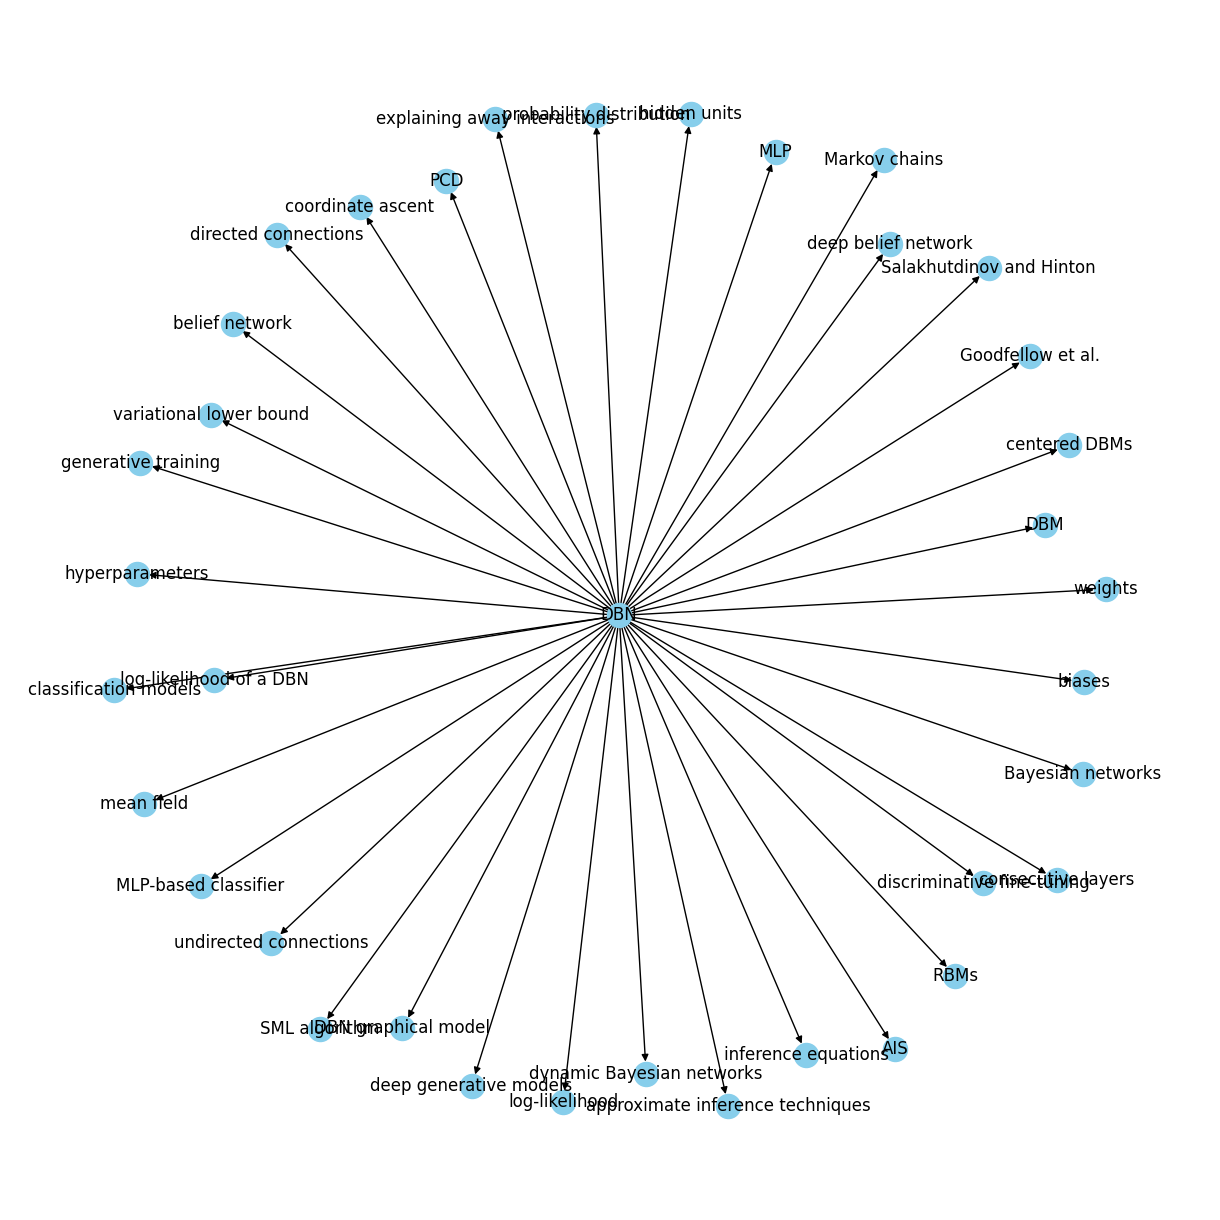

In [323]:
plt.figure(figsize=(12,12))


pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## 一些其他尝试

### N - Gram

In [33]:
# 暂时没有探索结果
# all_text = re.sub('[^A-Za-z0-9\.]+', ' ', text).lower().split(' ')
# ng1 = collections.defaultdict(int)
# ng2 = collections.defaultdict(int)
# ng3 = collections.defaultdict(int)
# ng4 = collections.defaultdict(int)
# for i, j in enumerate(all_text):
#     ng1[j] += 1
#     if i > 0: ng2[(all_text[i-1], j)] += 1
#     if i > 1: ng3[(all_text[i-2], all_text[i-1], j)] += 1
#     if i > 2: ng4[(all_text[i-3], all_text[i-2], all_text[i-1], j)] += 1

# def sort_feq(dic):
#     return sorted([(k, v) for k, v in dic.items()], key=lambda x: x[1], reverse=True)